In [ ]:
!pip install transformers torch sentence_transformers
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

# 1) Contrastive Language - Image Pretraining (CLIP)
https://towardsdatascience.com/understanding-zero-shot-learning-making-ml-more-human-4653ac35ccab

<img src="https://miro.medium.com/max/700/1*Jvnkpu3gR0ypolOtmatU0g.png" style="width:380px;height:400px;">

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging
import clip
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torchvision.datasets import CIFAR100

# clip model selection
print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Preprocess step:", preprocess)

Input resolution: 224
Context length: 77
Vocab size: 49408
Preprocess step: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fd4d930f680>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


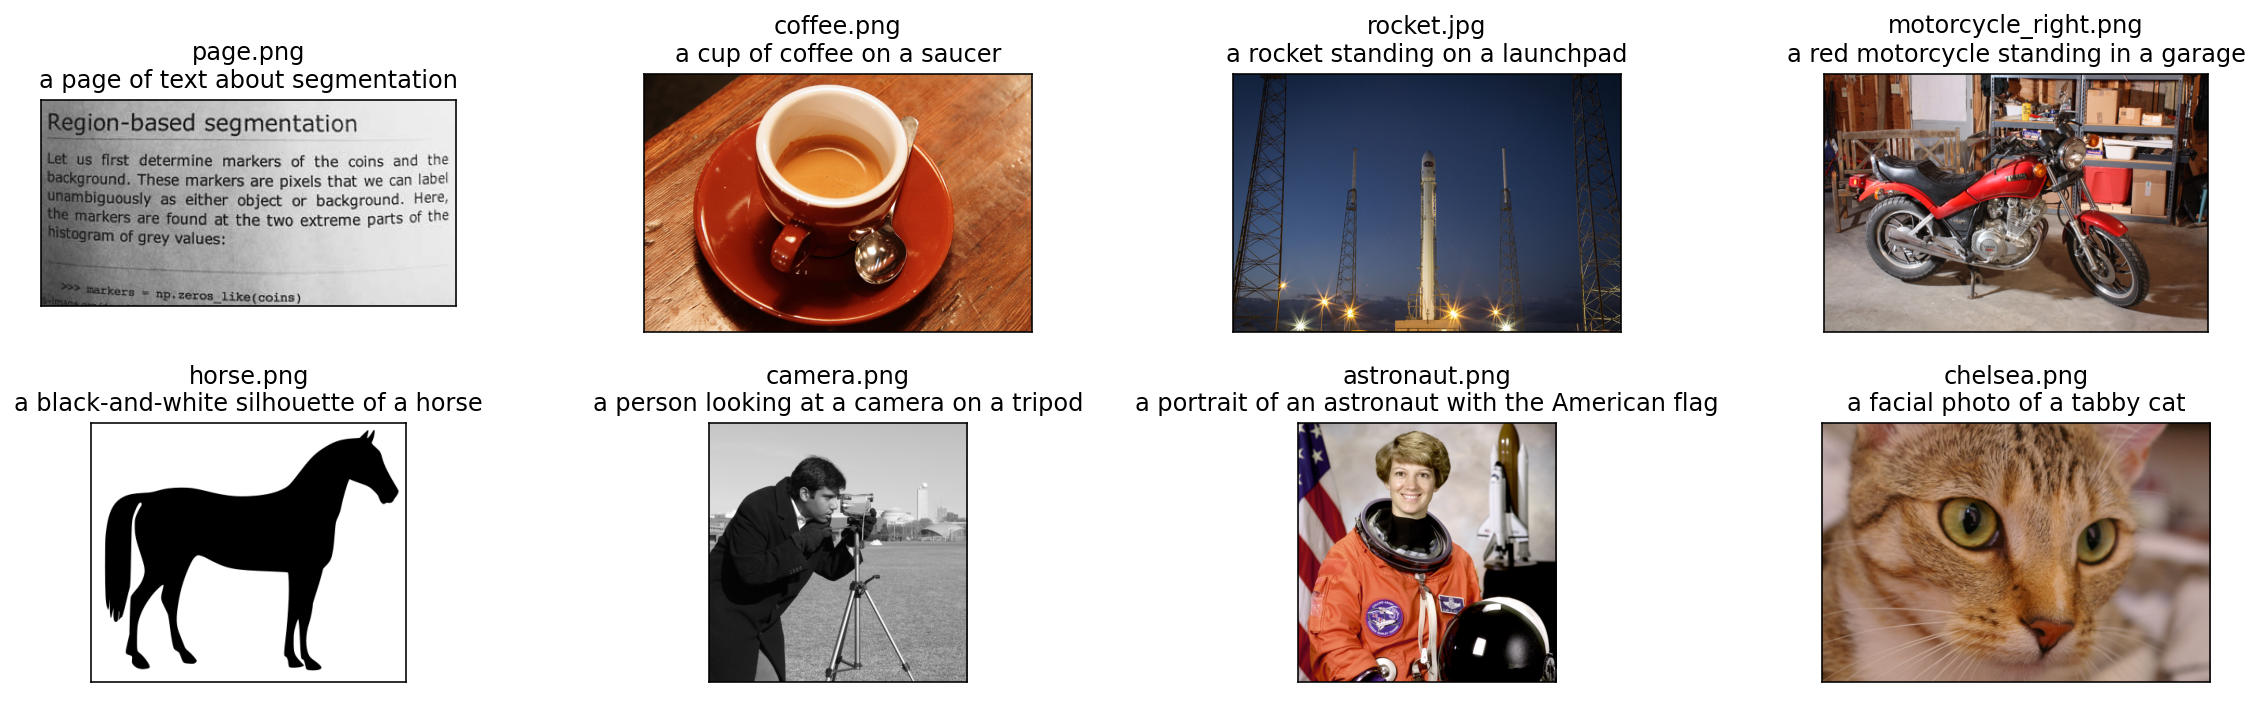

In [ ]:
# textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [ ]:
# encode images and text
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# normalized features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# cosine similarity
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
# result = 1 - spatial.distance.cosine(text_features.cpu().numpy()[0], image_features.cpu().numpy()[0])

Text(0.5, 1.0, 'Cosine similarity between text and image features')

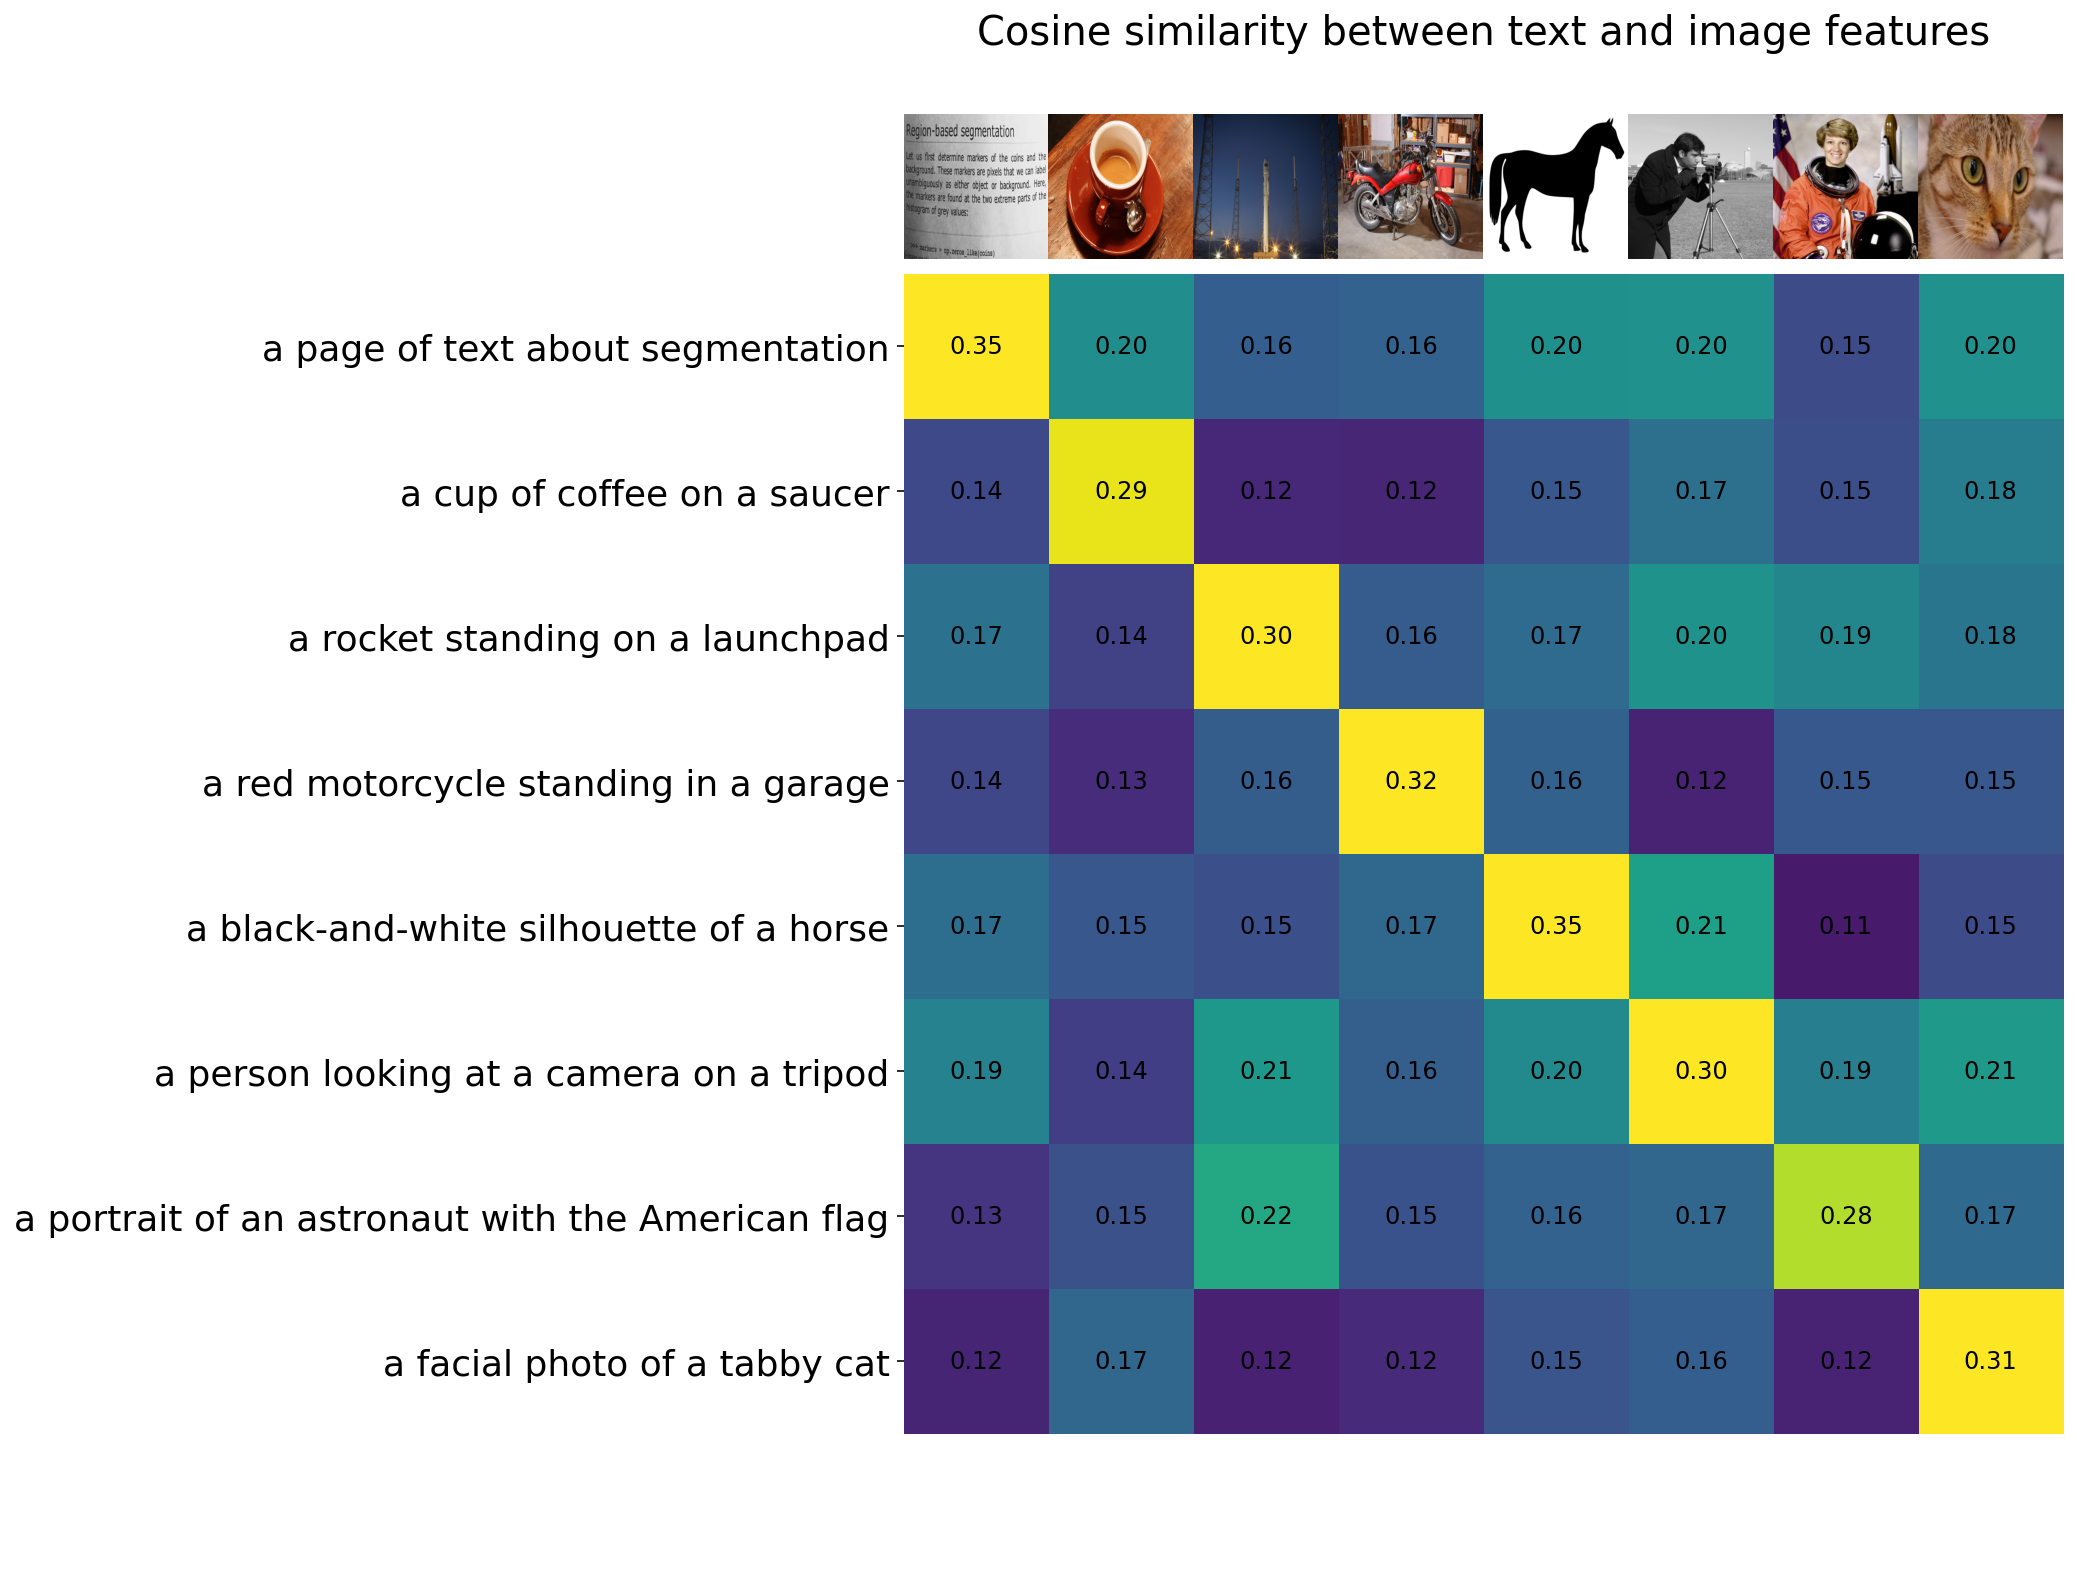

In [ ]:
# plotting
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [ ]:
# download data
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

# get text label and tokenize
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)

# encode texts and images
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


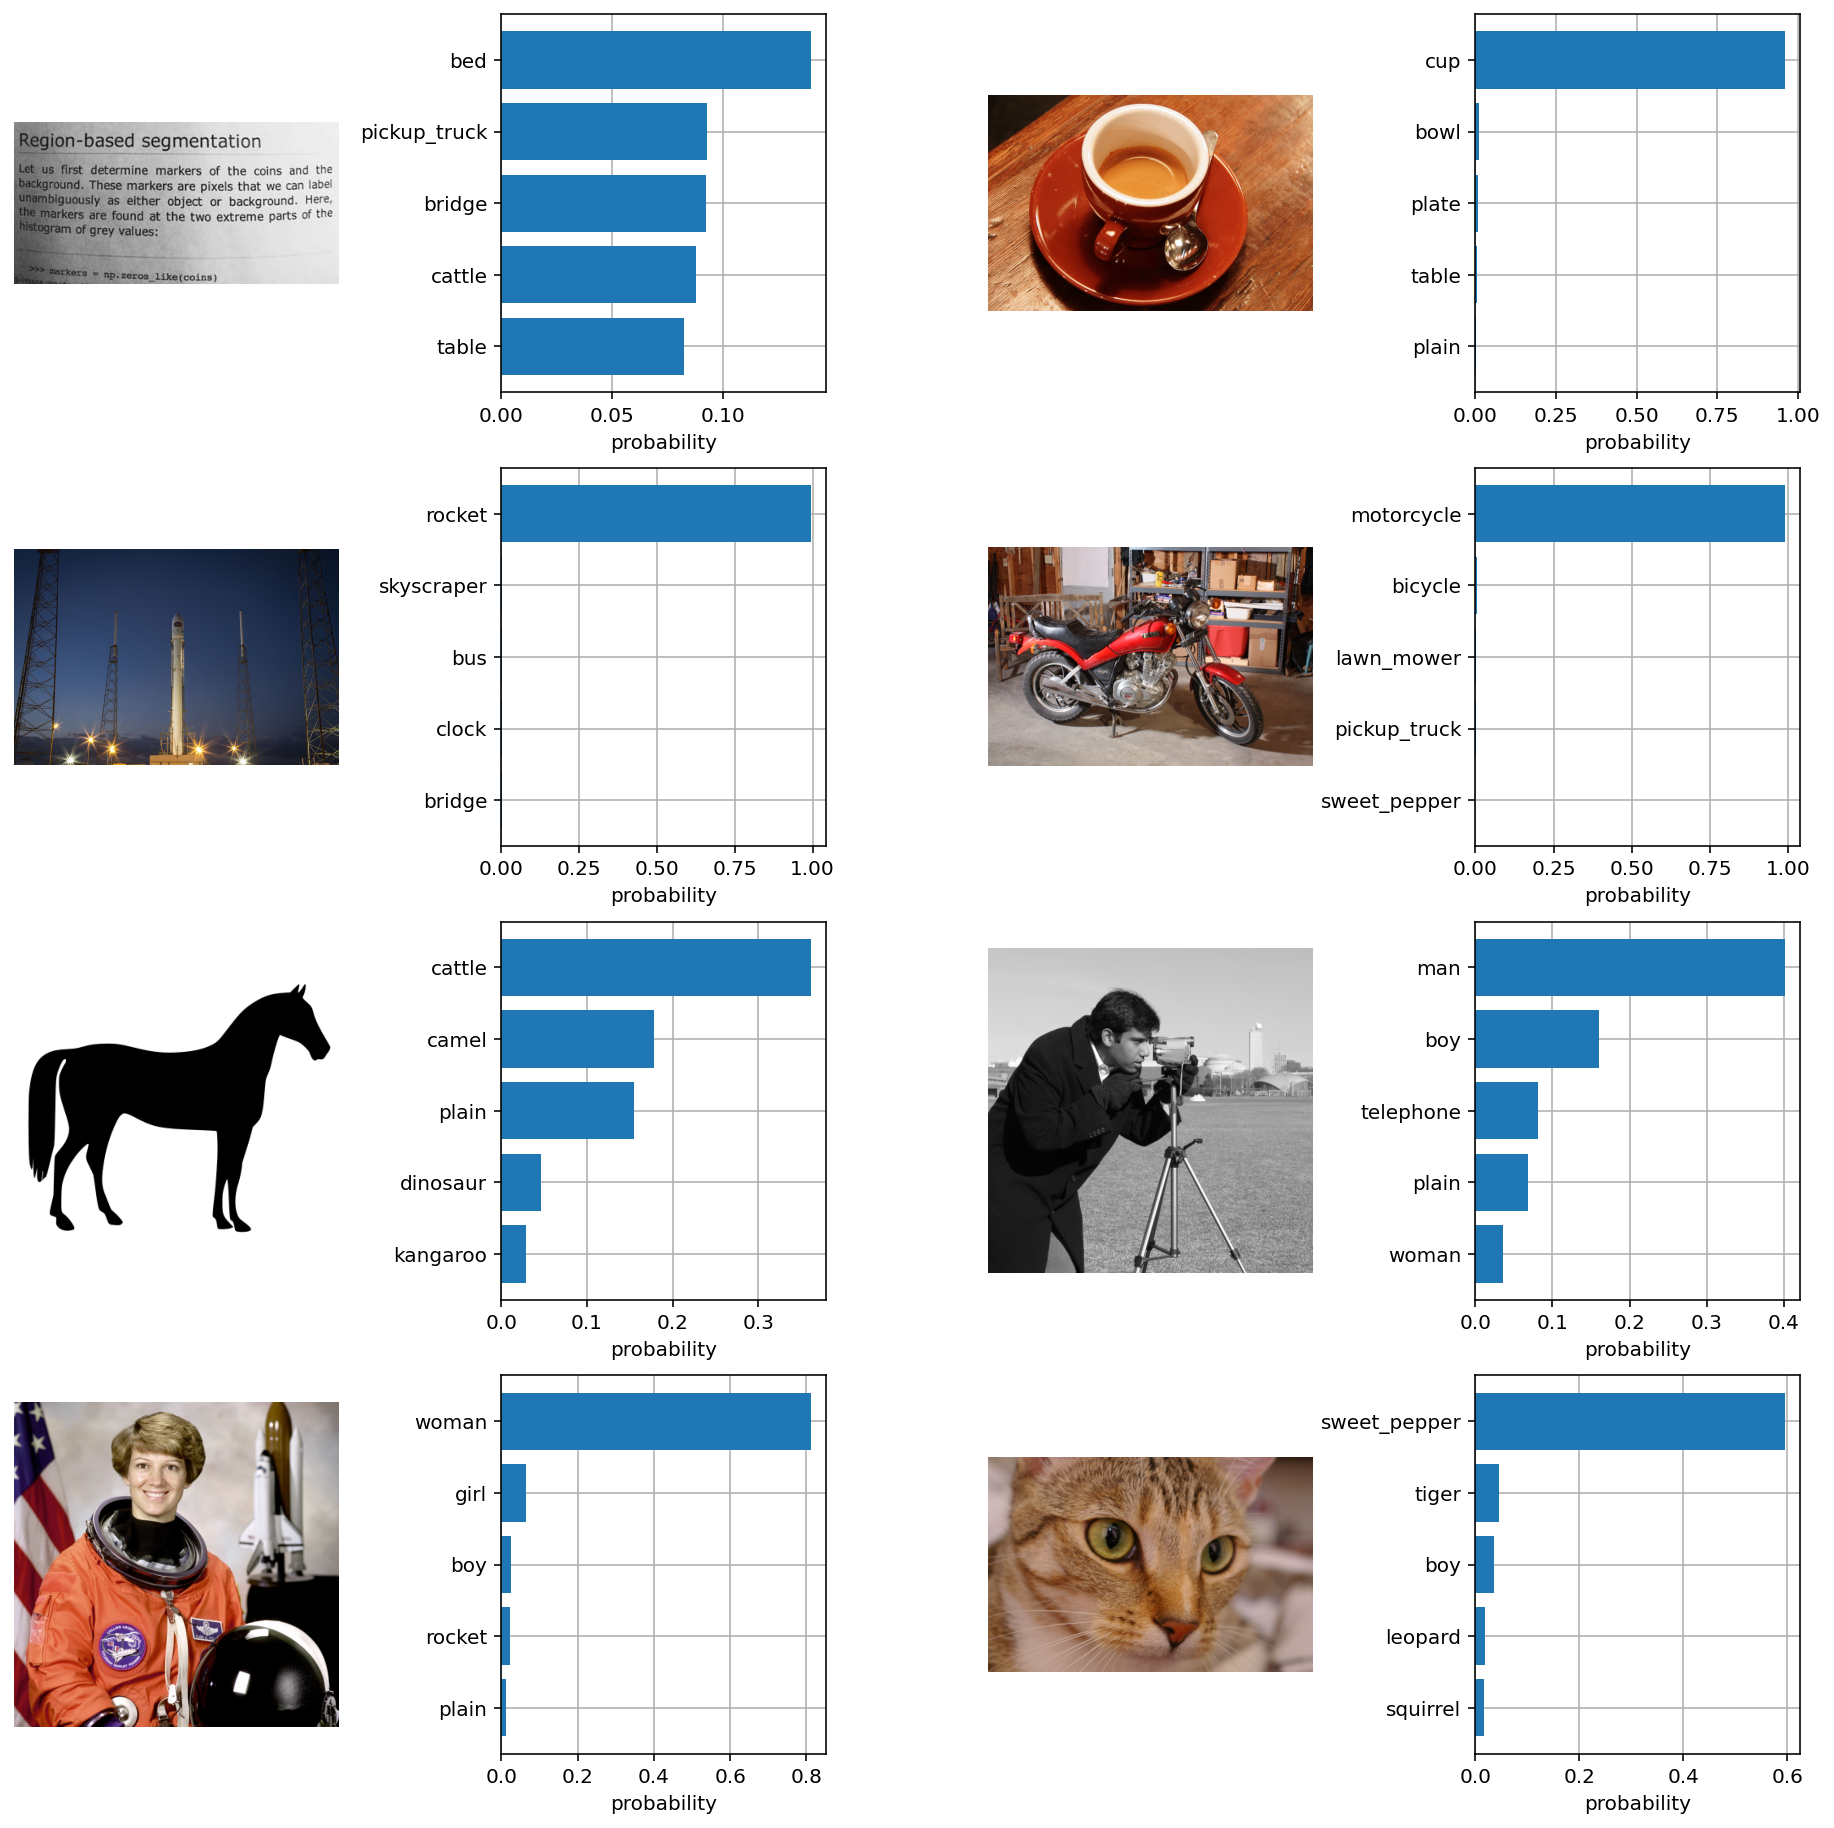

In [ ]:
# ploting
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# 2) Train CLIP
https://towardsdatascience.com/how-to-train-your-clip-45a451dcd303

In [ ]:
import torch.nn.functional as F

# encode images and text
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# forward in the script
temperature = 1.0

# diagonal should be highest, the rest keep low
logits = (text_features @ image_features.T) / temperature
print(f"Logits: {logits}")

# by dot product of own set, the diagonal (ground truth) is always the max
images_similarity = image_features @ image_features.T
texts_similarity = text_features @ text_features.T
similarity_sum = images_similarity + texts_similarity
targets = F.softmax(similarity_sum / 2 * temperature, dim=-1)

print(f"Image Features Size: {image_features.size()}")
print(f"Image Similarity Size: {images_similarity.size()}")
print(f"Image Similarity: {torch.round(F.softmax(images_similarity, dim=-1))}")
print(f"Similarity Sum: {torch.round(F.softmax(similarity_sum, dim=-1))}")
print(f"Target: {torch.round(targets)}")

# calculate loss
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = torch.nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

texts_loss = cross_entropy(logits, targets, reduction='none')
images_loss = cross_entropy(logits.T, targets.T, reduction='none')
loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)

print("\n")
print(f"Text Loss: {texts_loss}")
print(f"Image Loss: {images_loss}")
print(f"Total Loss: {loss.mean()}")

Logits: tensor([[33.2696, 24.6176, 18.4136, 18.3308, 23.9262, 24.2702, 14.6350, 24.7613],
        [11.5356, 31.0385, 12.0913, 11.6624, 15.7397, 17.9119, 12.6140, 19.3245],
        [13.6487, 14.3071, 29.1193, 14.8133, 16.9521, 20.2440, 15.9427, 18.2268],
        [10.1533, 11.7671, 13.9189, 27.2579, 14.7033, 10.9238, 11.6849, 14.3733],
        [11.8619, 13.9962, 12.5501, 13.7476, 30.2675, 18.7718,  8.3584, 13.1232],
        [15.5727, 14.8992, 20.9650, 15.8524, 20.5030, 32.2410, 16.2750, 22.5205],
        [ 9.7296, 14.7730, 20.2748, 13.4221, 15.5131, 15.8987, 21.9682, 16.4907],
        [ 8.6578, 15.6923, 10.4381, 10.6847, 13.9201, 14.6388,  9.0804, 28.8276]])
Image Features Size: torch.Size([8, 512])
Image Similarity Size: torch.Size([8, 8])
Image Similarity: tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0.